## 일반적인 흐름
스크립트는 에이전트(이 경우 여러 에이전트)가 환경과 이산 시간 단계에서 상호 작용하여 행동을 취하고, 관찰(상태)을 기반으로 보상을 받으며, 누적 보상을 최대화하기 위해 정책을 업데이트하는 전형적인 강화 학습 설정을 따릅니다. 훈련 루프(train(...))는 학습 과정과 MEC 환경의 시뮬레이션을 모두 주도하는 시뮬레이션의 핵심입니다.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# colab을 working directory로 옮기기
# https://codingalone.tistory.com/2

%cd /content/drive/MyDrive/QECO
!pwd

/content/drive/MyDrive/QECO
/content/drive/MyDrive/QECO


In [ ]:
import torch
if torch.cuda.is_available():
  print('gpu')
else:
  print('cpu')

gpu


In [ ]:
from MEC_Env import MEC
from DDQN_torch_bilstm import DuelingDoubleDeepQNetwork
# from DDQN_torch_bilstm_half import DuelingDoubleDeepQNetwork
from Config import Config
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import shutil
from sklearn.metrics import r2_score

## reward_fun(...)
- 목적: MEC 환경에서 주어진 조건에 대한 보상을 계산합니다. 보상 함수는 에이전트가 유리한 행동을 하도록 유도하기 때문에 강화 학습에서 매우 중요합니다.
- 파라미터: 다양한 구성 요소(UE 계산, UE 전송, 엣지 계산, UE 대기)에 의한 에너지 소비, 지연, 최대 허용 지연, 미완성 작업 지시자 등이 포함됩니다.
- 과정: 에너지 소비와 지연을 기반으로 보상을 계산하며, 에너지 사용과 미완성 작업에 대해 크게 벌칙을 주어 에너지 효율성과 작업 완성을 장려합니다.


In [ ]:
# 보상 값을 계산합니다. 작업이 완료되지 않았으면 패널티를 부과합니다. 그리고 공통으로 계산에 쓰인 에너지 소비를 차감합니다.
def reward_fun(ue_comp_energy, ue_trans_energy, edge_comp_energy, ue_idle_energy, delay, max_delay, unfinish_task):
    # edge_comp_energy 값중  e!=0 일때의 generator을 뽑아서 next에 넘겨줌. 그리고 next로 값 추출
    edge_energy  = next((e for e in edge_comp_energy if e != 0), 0)
    idle_energy = next((e for e in ue_idle_energy if e != 0), 0)
    penalty     = -max_delay*4
    if unfinish_task == 1:
        reward = penalty
    else:
        reward = 0
    reward = reward - (ue_comp_energy + ue_trans_energy + edge_energy + idle_energy)
    return reward

## monitor_reward(...), monitor_delay(...), monitor_energy(...)
- 목적: 훈련 도중 모니터링을 위해 모든 UE에 대한 통계(보상, 지연, 에너지 소비)를 집계하고 출력합니다. 시스템의 성능을 이해하는 데 도움이 됩니다.
- 파라미터: UE 목록(ue_RL_list)과 현재 에피소드 번호가 포함됩니다.
- 과정: 주어진 에피소드에 대해 UE 목록을 반복하며 저장된 값(보상, 지연, 에너지)을 합산한 다음 평균을 계산하여 출력합니다.

In [ ]:
# 에피소드 t에서의 UE들의 평균 reward, delay, energy을 계신합니다.
def monitor_reward(ue_RL_list, episode):
    episode_sum_reward = sum(sum(ue_RL.reward_store[episode]) for ue_RL in ue_RL_list)
    avg_episode_sum_reward = episode_sum_reward / len(ue_RL_list)
    print(f"reward: {avg_episode_sum_reward}")
    return avg_episode_sum_reward

def monitor_delay(ue_RL_list, episode):
    delay_ue_list = [sum(ue_RL.delay_store[episode]) for ue_RL in ue_RL_list]
    avg_delay_in_episode = sum(delay_ue_list) / len(delay_ue_list)
    print(f"delay: {avg_delay_in_episode}")
    return avg_delay_in_episode

def monitor_energy(ue_RL_list, episode):
    energy_ue_list = [sum(ue_RL.energy_store[episode]) for ue_RL in ue_RL_list]
    avg_energy_in_episode = sum(energy_ue_list) / len(energy_ue_list)
    print(f"energy: {avg_energy_in_episode}")
    return avg_energy_in_episode



## cal_reward(...)
- 목적: 모든 에피소드와 UE에 걸쳐 총 보상과 평균 보상을 계산하고 출력합니다.
- 파라미터: UE 목록(ue_RL_list)이 포함됩니다.
- 과정: 각 UE와 각 에피소드를 반복하며 보상을 합산하여 총 보상과 평균 보상을 계산한 후 출력합니다.

In [ ]:
def cal_reward(ue_RL_list):
    total_sum_reward = 0
    num_episodes = 0
    for ue_num, ue_RL in enumerate(ue_RL_list):
        print("________________________")
        print("ue_num:", ue_num)
        print("________________________")
        for episode, reward in enumerate(ue_RL.reward_store):
            print("episode:", episode)
            reward_sum = sum(reward)
            print(reward_sum)
            total_sum_reward += reward_sum
            num_episodes += 1
    avg_reward = total_sum_reward / num_episodes
    print(total_sum_reward, avg_reward)




## train(...)
- 목적: DRL 알고리즘이 MEC 환경과 상호 작용하여 작업 오프로딩을 최적화하는 방법을 학습하는 주요 훈련 루프입니다.
- 파라미터: 각 UE에 대해 듀얼링 DDQN 에이전트가 장착된 UE 목록(ue_RL_list), 실행할 에피소드 수(NUM_EPISODE)가 포함됩니다.
- 과정:
각 에피소드에 대해 작업 도착을 시뮬레이션하고 MEC 환경을 초기화합니다.
각 시간 단계마다 현재 상태를 기반으로 각 UE에 대한 행동을 결정하는 루프에 들어갑니다.
이러한 행동을 환경에서 실행하여 다음 상태와 보상을 관찰합니다.
이 경험을 기반으로 듀얼링 DDQN 모델을 주기적으로 업데이트합니다.
보상, 지연, 에너지 소비, 작업 드롭률과 같은 성능 지표를 모니터링하며, 필요한 경우 모델을 저장하고 그림을 그립니다.

In [ ]:
drop_rate_list = []
drop_task_list = []
complete_task_list = []

In [ ]:
def train(ue_RL_list, NUM_EPISODE):
    global n_ue
    # """에피소드별로 평균 보상, 지연, 에너지 소비, 작업 드롭률을 추적하기 위한 리스트들을 초기화하고,
    #  강화 학습 스텝을 카운팅하는 변수 RL_step을 초기화합니다."""

    avg_reward_list = []
    avg_reward_list_2 = []
    avg_delay_list_in_episode = []
    avg_energy_list_in_episode = []
    num_task_drop_list_in_episode = []
    RL_step = 0
    a = 1



    for episode in range(NUM_EPISODE):
        print("episode  :", episode)
        print("epsilon  :", ue_RL_list[0].epsilon)
        # 현재 에피소드 번호와 탐험을 위한 epsilon 값(첫 번째 UE의 에이전트를 참조하여)을 출력합니다.


        # BITRATE ARRIVAL
        # 각 UE에 대한 작업 도착을 시뮬레이션합니다.
        # 이는 각 시간 단계에 대해 임의의 작업 크기와 도착 확률을 생성하고,
        # 최대 지연 시간을 고려하여 작업 배열을 조정합니다.

        bitarrive = np.random.uniform(env.min_arrive_size, env.max_arrive_size, size=[env.n_time, env.n_ue])
        task_prob = env.task_arrive_prob  # TASK_ARRIVE_PROB: 작업 도착 확률 -> 30% 확률로 task 도착
        bitarrive = bitarrive * (np.random.uniform(0, 1, size=[env.n_time, env.n_ue]) < task_prob)
        # delay가 발생하여서 뒤에 max_delay만큼은 not bit arrive -> 110-10 = 100 time_slot만 걸리게,, (근데 굳이?)
        bitarrive[-env.max_delay:, :] = np.zeros([env.max_delay, env.n_ue])
        print('bitarive:', bitarrive) # row 수 = 전체시간, col 수` = ue 개수

        # OBSERVATION MATRIX SETTING
        # 각 시간 단계와 UE에 대한 관찰, LSTM 상태, 행동,
        # 그리고 다음 상태를 추적하기 위한 history 리스트와 보상 지시자를 초기화합니다.

        history = list()
        for time_index in range(env.n_time):
            history.append(list())
            for ue_index in range(env.n_ue):
                tmp_dict = {'observation': np.zeros(env.n_features),
                            'lstm': np.zeros(env.n_lstm_state),
                            'action': np.nan,
                            'observation_': np.zeros(env.n_features),
                            'lstm_': np.zeros(env.n_lstm_state)}
                history[time_index].append(tmp_dict)
        reward_indicator = np.zeros([env.n_time, env.n_ue])

        # INITIALIZE OBSERVATION
        # 환경을 초기 상태로 리셋하고, 초기 관찰 및 LSTM 상태를 가져옵니다.
        observation_all, lstm_state_all = env.reset(bitarrive)

        # TRAIN DRL
        # 무한 루프를 시작하여 에이전트가 환경과 상호 작용하게 합니다.
        # 이 루프는 에피소드가 끝날 때(done == True일 때)까지 계속됩니다.

        while True:

            # PERFORM ACTION
            # 각 UE에 대해 행동을 결정하고 저장합니다.
            #  이는 현재 관찰에 기반하여 각 UE의 에이전트가 최적의 행동을 선택하게 합니다.

            # action_all -> 각 ue의 offloading decision Algorithm1 (line 4~7)
            action_all = np.zeros([env.n_ue])
            for ue_index in range(env.n_ue):
                observation = np.squeeze(observation_all[ue_index, :])
                if np.sum(observation) == 0:
                    # if there is no task, action = 0 (also need to be stored)
                    action_all[ue_index] = 0
                else:
                    # Algorithm1 line 7
                    action_all[ue_index] = ue_RL_list[ue_index].choose_action(observation)
                    if observation[0] != 0: # 관측이 되었다면 action store. ques) obeservation(state)가 0 은 무슨 의미? 배열이잖아. -> task가 없다는 의미다.
                        # DQN에 메모리 저장
                        ue_RL_list[ue_index].do_store_action(episode, env.time_count, action_all[ue_index])

            # OBSERVE THE NEXT STATE AND PROCESS DELAY (REWARD)
            # 선택된 행동을 환경에 적용하고, 다음 상태, LSTM 상태, 그리고 에피소드가 끝났는지 여부를 반환받습니다.
            # Algorithm1 Line 9-10
            # action_all = (n_ue, )
            observation_all_, lstm_state_all_, done = env.step(action_all)

            # should store this information in EACH time slot
            # 각 UE에 대한 정보를 업데이트하고, 환경에서 얻은 결과를 기반으로 학습 데이터(트랜지션)를 저장합니다.
            # LSTM 저장
            # Algorithm1 Line 11-12 XX
            for ue_index in range(env.n_ue):
                ue_RL_list[ue_index].update_lstm(lstm_state_all_[ue_index,:])

            # STORE MEMORY; STORE TRANSITION IF THE TASK PROCESS DELAY IS JUST UPDATED
            # observation_all, observation_all_ 차이 env.step 하기 전, 후의 값
            for ue_index in range(env.n_ue):
                obs = observation_all[ue_index, :]
                lstm = np.squeeze(lstm_state_all[ue_index, :])
                action = action_all[ue_index]
                obs_ = observation_all_[ue_index]
                lstm_ = np.squeeze(lstm_state_all_[ue_index,:])
                history[env.time_count - 1][ue_index].update({
                    'observation': obs,
                    'lstm': lstm,
                    'action': action,
                    'observation_': obs_,
                    'lstm_': lstm_
                })
                # reward_indicator 배열에서 특정 열의 값이 1이아니고, 해당요소의 env.process_delay가 0보다 큰 경우의 인덱스를 찾아 update_index에 저장
                update_index = np.where((1 - reward_indicator[:,ue_index]) *env.process_delay[:,ue_index] > 0)[0]
                # print(update_index)
                if len(update_index) != 0:
                    for time_index in update_index:
                        reward = reward_fun(
                            env.ue_comp_energy[time_index, ue_index],
                            env.ue_tran_energy [time_index, ue_index],
                            env.edge_comp_energy[time_index, ue_index],
                            env.ue_idle_energy[time_index, ue_index],
                            env.process_delay[time_index, ue_index],
                            env.max_delay,
                            env.unfinish_task[time_index, ue_index]
                        )
                        # Training Process Line 10
                        # transition(현재 state, action, reward, 다음 state)
                        ue_RL_list[ue_index].store_transition(
                            history[time_index][ue_index]['observation'],
                            history[time_index][ue_index]['lstm'],
                            history[time_index][ue_index]['action'],
                            reward,
                            history[time_index][ue_index]['observation_'],
                            history[time_index][ue_index]['lstm_']
                        )
                        ue_RL_list[ue_index].do_store_reward(
                            episode,
                            time_index,
                            reward
                        )
                        ue_RL_list[ue_index].do_store_delay(
                            episode,
                            time_index,
                            env.process_delay[time_index, ue_index]
                        )
                        ue_RL_list[ue_index].do_store_energy(
                            episode,
                            time_index,
                            env.ue_comp_energy[time_index, ue_index],
                            env.ue_tran_energy [time_index, ue_index],
                            env.edge_comp_energy[time_index, ue_index],
                            env.ue_idle_energy[time_index, ue_index]
                        )
                        reward_indicator[time_index, ue_index] = 1

            # Algorithm2 Training Process Line 18
            # ADD STEP (one step does not mean one store)
            RL_step += 1

            # UPDATE OBSERVATION
            observation_all = observation_all_
            lstm_state_all = lstm_state_all_

            # Algorithm2 Training Process Line 19-20
            # CONTROL LEARNING START TIME AND FREQUENCY
            # 일정 스텝마다 모든 UE의 에이전트가 학습을 수행하도록 합니다.
            # 여기서는 200 스텝 이후부터 10의 배수 스텝마다 학습을 진행합니다.
            if (RL_step > 200) and (RL_step % 10 == 0):
                for ue in range(env.n_ue):
                    ue_RL_list[ue].learn()

            # GAME ENDS
            # 에피소드가 끝났을 경우(예: 모든 작업이 처리되거나 시간이 끝났을 때),
            # 작업의 완료 상태, 드롭률, 에너지 소비 등을 계산하고 출력한 후 루프를 종료합니다.

            if done:
                for task in env.task_history:
                    cmpl = drp = 0
                    for t in task:
                        d_states = t['d_state']
                        if any(d < 0 for d in d_states):
                            t['state'] = 'D'
                            drp += 1
                        elif all(d > 0 for d in d_states):
                            t['state'] = 'C'
                            cmpl += 1
                full_complete_task = 0
                full_drop_task = 0
                complete_task = 0
                drop_task = 0
                for history in env.task_history:
                    for task in history:
                        if task['state'] == 'C':
                            full_complete_task += 1
                        elif task['state'] == 'D':
                            full_drop_task += 1
                        for component_state in task['d_state']:
                            if component_state == 1:
                                complete_task += 1
                            elif component_state == -1:
                                drop_task += 1
                # MEC line 170 self.task_history[ue_index].append(task_dic)
                # ?? (MD의 개수)*( MD 0의 history 개수)*n_compnent -> 왜 이렇게 했을까? 1. 모든 MD의 도착 task 수 같음 or 2. 대충 어림잡아 계산
                cnt = len(env.task_history) * len(env.task_history[0]) * env.n_component
                print(len(env.task_history), len(env.task_history[0]), cnt)
                print("++++++++++++++++++++++")
                print("drrop_rate   : ", full_drop_task/(cnt/env.n_component))
                print("full_drrop   : ", full_drop_task)
                print("full_complate: ", full_complete_task)
                print("complete_task: ", complete_task)
                print("drop_task:     ", drop_task)
                print("++++++++++++++++++++++")


                avg_reward_list.append(-(monitor_reward(ue_RL_list, episode)))
                if episode % 10 == 0:
                    avg_reward_list_2.append(sum(avg_reward_list[episode-10:episode])/10)
                    avg_delay_list_in_episode.append(monitor_delay(ue_RL_list, episode))
                    avg_energy_list_in_episode.append(monitor_energy(ue_RL_list, episode))
                    print('avg delay:, energy')
                    print(avg_delay_list_in_episode, avg_energy_list_in_episode)
                    total_drop = full_drop_task
                    num_task_drop_list_in_episode.append(total_drop)


                    # Writing data to files

                    data = [avg_reward_list, avg_delay_list_in_episode, avg_energy_list_in_episode, num_task_drop_list_in_episode]
                    filenames = ['reward.txt', 'delay.txt', 'energy.txt', 'drop.txt']
                    for i in range(len(data)):
                        with open(filenames[i], 'w') as f:
                            f.write('\n'.join(str(x) for x in data[i]))
                if episode == 0 or (episode+1)%50 == 0:
                  drop_rate_list.append(full_drop_task/(cnt/env.n_component))
                  drop_task_list.append(full_drop_task)
                  complete_task_list.append(full_complete_task)

                # Process energy
                ue_bit_processed = sum(sum(env.ue_bit_processed))
                ue_comp_energy = sum(sum(env.ue_comp_energy))

                # Transmission energy
                ue_bit_transmitted = sum(sum(env.ue_bit_transmitted))
                ue_tran_energy = sum(sum(env.ue_tran_energy))

                # edge energy
                edge_bit_processed = sum(sum(env.edge_bit_processed))
                edge_comp_energy = sum(sum(env.edge_comp_energy))
                ue_idle_energy = sum(sum(env.ue_idle_energy))

                # Print results
                print(int(ue_bit_processed), ue_comp_energy, "local")
                print(int(ue_bit_transmitted), ue_tran_energy, "trans")
                print(int(sum(edge_bit_processed)),sum(edge_comp_energy), sum(ue_idle_energy), "edge")
                print("_________________________________________________")

                break # Training Finished

    x=np.array(list(range(0, NUM_EPISODE//10)))
    x_r = np.array(list(range(0, NUM_EPISODE)))
    line_reward_1 = np.polyfit(x_r, avg_reward_list, 1)
    line_reward_2 = np.polyfit(x, avg_reward_list_2, 1)
    line_delay = np.polyfit(x, avg_delay_list_in_episode, 1)
    line_energy = np.polyfit(x, avg_energy_list_in_episode, 1)
    line_drop = np.polyfit(x, num_task_drop_list_in_episode, 1)
    x_minmax = np.array([0, NUM_EPISODE//10])
    x_r_minmax = np.array([0, NUM_EPISODE])

    fit_reward_y_1 = x_r_minmax * line_reward_1[0] + line_reward_1[1]
    fit_reward_y_2 = x_minmax * line_reward_2[0] + line_reward_2[1]
    fit_delay_y = x_minmax * line_delay[0] + line_delay[1]
    fit_energy_y = x_minmax * line_energy[0] + line_energy[1]
    fit_drop_y = x_minmax * line_drop[0] + line_drop[1]

    fig1, ax1 = plt.subplots(figsize=(8, 8))
    ax1.plot(avg_delay_list_in_episode, '-')
    ax1.set_ylabel('Average Delay(ms)')
    ax1.set_xlabel('epoch 수')
    ax1.plot(x_minmax, fit_delay_y, color='orange')
    fig1.savefig('fig-delay.png')

    # 두 번째 그래프를 위한 figure 생성
    fig2, ax2 = plt.subplots(figsize=(8, 8))
    ax2.plot(avg_energy_list_in_episode, '-')
    ax2.set_ylabel('Average Energy(Jx10)')
    ax2.set_xlabel('epoch 수')
    ax2.plot(x_minmax, fit_energy_y, color='orange')
    fig2.savefig('fig-energy.png')

    est_reward_y_1 = x_r*line_reward_1[0] + line_reward_1[1]
    est_reward_y_2 = x*line_reward_2[0] + line_reward_2[1]
    est_delay_y = x*line_delay[0] + line_delay[1]
    est_energy_y = x*line_energy[0] + line_energy[1]
    est_drop_y = x*line_drop[0] + line_drop[1]

    r2s = [r2_score(avg_reward_list, est_reward_y_1),
            r2_score(avg_reward_list_2, est_reward_y_2),
            r2_score(avg_delay_list_in_episode, est_delay_y),
            r2_score(avg_energy_list_in_episode, est_energy_y),
            r2_score(num_task_drop_list_in_episode, est_drop_y)]

    print("R2 - Reward :", r2s[0])
    print("R2 - avg Reward :", r2s[1])
    print("R2 - Delay :", r2s[2])
    print("Delay: y = {0}x+{1}".format(line_delay[0], line_delay[1]))
    print("R2 - Energy :", r2s[3])
    print("Energy: y = {0}x+{1}".format(line_energy[0], line_energy[1]))
    print("R2 - Drop :", r2s[4])
    r2_file = 'R2-'+str(n_ue)+'.txt'
    with open(r2_file, 'w') as f:
      for i in range(len(r2s)):
        f.write('\n'.join(str(r2s[i])))


## if __name__ == "__main__":
- 목적: 스크립트가 독립 실행 프로그램으로 실행될 때의 진입점입니다. 환경을 설정하고, 각 UE에 대해 듀얼링 DDQN 에이전트를 초기화하며, 훈련 프로세스를 시작합니다.
- 과정:
Config에서 제공하는 파라미터로 MEC 환경을 초기화합니다.
각 UE에 대한 듀얼링 DDQN 에이전트 목록을 생성하고 구성합니다.
시뮬레이션 및 학습 프로세스를 시작하기 위해 train(...) 함수를 호출합니다.

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
110 26 2860
++++++++++++++++++++++
drrop_rate   :  0.3083916083916084
full_drrop   :  882
full_complate:  1904
complete_task:  1904
drop_task:      882
++++++++++++++++++++++
reward: -676.9928890142473
7846 18642.19838569988 local
1202 4081.207504240452 trans
726 25.811901626856287 0.0 edge
_________________________________________________
episode  : 356
epsilon  : 0.9739999999999205
bitarive: [[0.         0.         2.15564567 ... 3.70633583 0.         4.94342494]
 [0.         4.73311855 0.         ... 0.         3.99259544 0.        ]
 [4.80094138 0.         3.78482546 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         

<ipython-input-10-36da86a4f637>:287: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  plt.savefig('figures.png')


R2 - Reward : 0.5641988975236452
R2 - avg Reward : 0.23902237704243656
R2 - Delay : 0.8662329145004647
Delay: y = -4.378870675542952x+618.3652406417112
R2 - Energy : 0.5934553165728064
Energy: y = -0.6607058412628916x+239.51070144933828
R2 - Drop : 0.7405614118998283


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


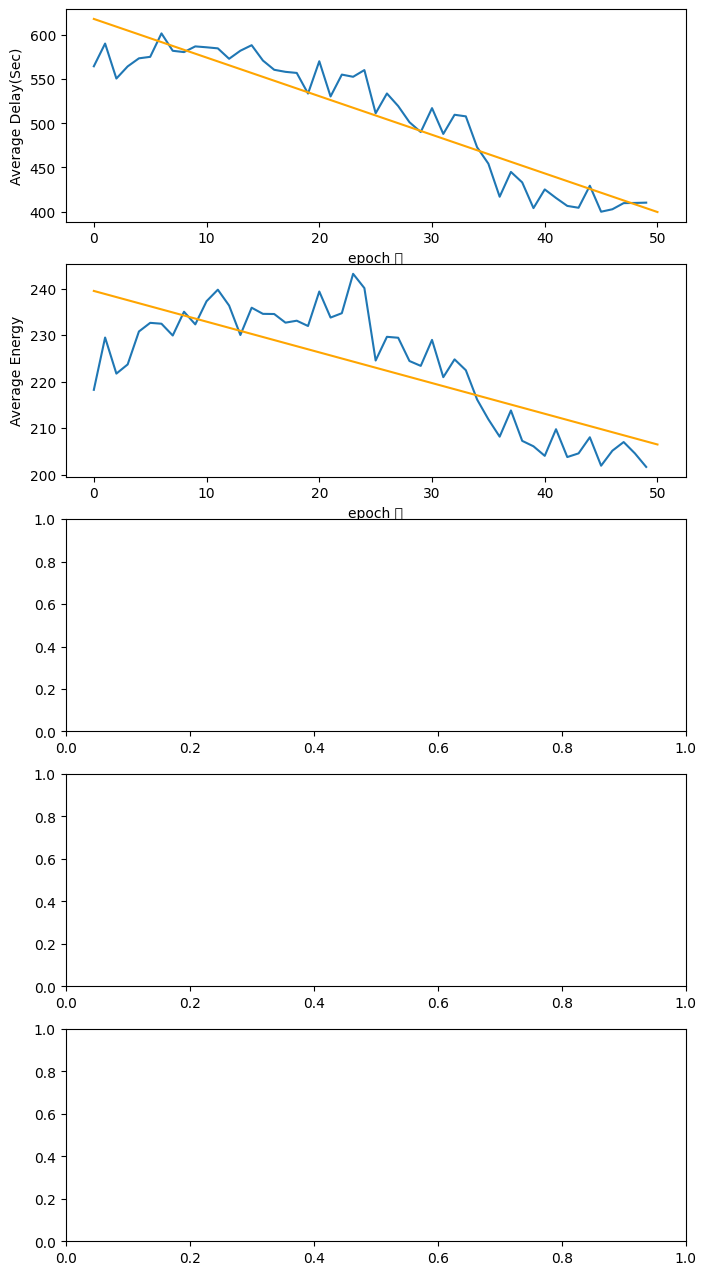

In [ ]:
# GENERATE ENVIRONMENT
# n_ue = Config.N_UE
n_ue = 110
env = MEC(n_ue, Config.N_EDGE, Config.N_TIME, Config.N_COMPONENT, Config.MAX_DELAY)

# GENERATE MULTIPLE CLASSES FOR RL
ue_RL_list = list()
for ue in range(n_ue):
    ue_RL_list.append(DuelingDoubleDeepQNetwork(env.n_actions, env.n_features, env.n_lstm_state, env.n_time,
                                                learning_rate       = Config.LEARNING_RATE,
                                                reward_decay        = Config.REWARD_DDECAY,
                                                e_greedy            = Config.E_GREEDY,
                                                replace_target_iter = Config.N_NETWORK_UPDATE,  # each 200 steps, update target net
                                                memory_size         = Config.MEMORY_SIZE,  # maximum of memory
                                                doLC                = False # Local Computing
                                                ))

# LOAD MODEL
'''
for ue in range(Config.N_UE):
    ue_RL_list[ue].Initialize(ue_RL_list[ue].sess, ue)
'''

# TRAIN THE SYSTEM
train(ue_RL_list, 500)

filenames = ['bilstm_drop_rate_list_'+str(n_ue)+'.txt', 'bilstm_drop_task_list_'+str(n_ue)+'.txt', 'bilstm_compelete_task_list_'+str(n_ue)+'.txt']
with open(filenames[0], 'w') as f:
    f.write('\n'.join(str(x) for x in drop_rate_list))
with open(filenames[1], 'w') as f:
    f.write('\n'.join(str(x) for x in drop_task_list))
with open(filenames[2], 'w') as f:
    f.write('\n'.join(str(x) for x in complete_task_list))


In [ ]:
print(drop_rate_list)
print(drop_task_list)
print(complete_task_list)